# Frames and Coordinate Systems

## Authors

Lots of parts are from the orekit documentation, with some updates, simplifications and Pythonification by Petrus Hyvönen, SSC

## Learning Goals
* *What are frames*: How to work with frames and transformations in Orekit
* *How can I use pre-defined frames*: How to use and specify typical pre-defined frames 

## Keywords
orekit, frames

In [1]:
%matplotlib inline

Initialize orkit and bring up the python-java interface

In [2]:
import orekit
vm = orekit.initVM()

Now set up the pointer to the orekit-data.zip file, using one of the helper files. The file should be in current directory if not specified otherwise.

In [3]:
from orekit.pyhelpers import setup_orekit_curdir, absolutedate_to_datetime
setup_orekit_curdir()

Now we are set up to import and use objects from the orekit library. Packages can be imported as they were native Python packages

In [4]:
from org.hipparchus.geometry.euclidean.threed import Vector3D, SphericalCoordinates

In [5]:
from org.orekit.data import DataProvidersManager, ZipJarCrawler
from org.orekit.frames import FramesFactory, TopocentricFrame
from org.orekit.bodies import OneAxisEllipsoid, GeodeticPoint, CelestialBodyFactory
from org.orekit.time import TimeScalesFactory, AbsoluteDate, DateComponents, TimeComponents
from org.orekit.utils import IERSConventions, Constants, PVCoordinates, PVCoordinatesProvider, AbsolutePVCoordinates

from org.orekit.propagation.analytical.tle import TLE, TLEPropagator
from java.io import File

from math import radians, pi, degrees
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Frames

A coordinate system is anchored in specified reference points, called frames. The definition of these can be of vital importance to space missions.

The orekit package supports a number of pre-defined frames, and also advanced user defined frames. All frames but the root frame are related to a parent frame, so that it is possible to transform between any frames.

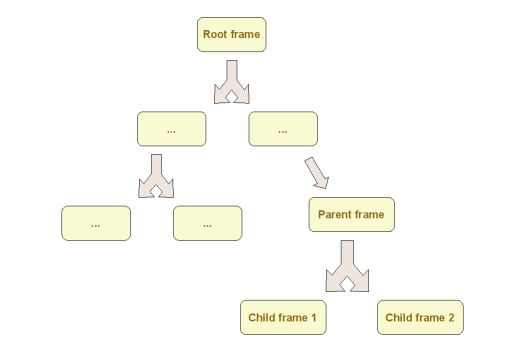

_Image from orekit documentation_

For example, if we request a pre-defined frame with a center located at the Sun's gravity center, and rotating with the Sun rotation (according to implemented models), we can trace the different frames that has been used, all the way to the root frame, the GCRF.

In [6]:
sun_frame = CelestialBodyFactory.getSun().getBodyOrientedFrame()

In [7]:
print(sun_frame, '\n',
      sun_frame.getParent(), '\n',
      sun_frame.getParent().getParent(), '\n',
      sun_frame.getParent().getParent().getParent(), '\n',
      sun_frame.getParent().getParent().getParent().getParent(),'\n',
     )

Sun/rotating 
 Sun/inertial 
 ICRF 
 Earth-Moon barycenter/inertial 
 GCRF 



# Example of pre-defined frames

There are a number of pre-defined frames in Orekit, and for most usages there will be little need to define own frames, although it is possible.

## Celestial & Inertial Frames

An inertial frame is a frame where there is no rotation of the frame with respect to the stars, and there is no acceleration of the origin of the frame. An object, where no forces are acting on it will continue to move along its velocity.

The definition of the orientation of the frame, and which stars or model that is use to define it (stars can move..) varies between different frames of this type.

## International Celestial Reference Frame

The [ICRF frame](https://www.iers.org/IERS/EN/DataProducts/ICRF/ICRF/icrf.html) is a modern intertial frame managed by te International Earth Rotation Service (IERS). The definition of the fram is based on the location of 295 extragalactic radio sources

In [8]:
icrf_frame = FramesFactory.getICRF()

In [9]:
icrf_frame.getParent().getParent()

<Frame: GCRF>

### Legacy frames EME2000 / J2000

The EME2000 / J2000 frame has been common in space and astronomy for decades, and is commonly occuring in the industry. The EME2000 frame in Orekit is close to the classical J2000 frame.

This frame is based on the Earth's equator and equinox, determined from observation of plaetary motion and other data.

- $X_{J2000}$: Defined by the intersection equatorial and ecliptic planes, called vernal equinox
- $Y_{J2000}$: The cross product of Z and X
- $Z_{J2000}$: Approximately the Earth's spin axis orientation (north) at 1 January 2000 12:00:00 ET/TBD


In [10]:
eme_frame = FramesFactory.getEME2000()

Let us create a position-velocity pair at an instance, as an example

In [11]:
position = Vector3D(3220103., 69623., 6449822.)
velocity = Vector3D(6414.7, -2006., -3180.)
pv_eme = PVCoordinates(position, velocity)
initDate = AbsoluteDate.J2000_EPOCH.shiftedBy(584.)

In [12]:
pv_eme

<PVCoordinates: {P(3220103.0, 69623.0, 6449822.0), V(6414.7, -2006.0, -3180.0), A(0.0, 0.0, 0.0)}>

# Non-Inertial Frames 

Non-inertial frames has some kind of acceleration in the frame, including rotation. Examples are body fixed frames, where the axis are fixed to the features of a body (such as a planet, a satellite, the Moon etc).

##  International Terrestrial Reference Frame (ITRF)

This frame is an Earth centric frame that rotates with the Earth and based on the International Terrestrial Reference System. This system is describe at the [IERS webpage](https://www.iers.org/IERS/EN/Science/ITRS/ITRS.html) and the frame is described at [ITRF page](https://www.iers.org/IERS/EN/DataProducts/ITRF/itrf.html)

It is based on the following conditions (from webpage):

- It is geocentric, the center of mass being defined for the whole earth, including oceans and atmosphere.
- The unit of length is the metre (SI). This scale is consistent with the TCG time coordinate for a geocentric local frame, in agreement with IAU and IUGG (1991) resolutions. This is obtained by appropriate relativistic modelling.
- Its orientation was initially given by the BIH orientation at 1984.0.
- The time evolution of the orientation is ensured by using a no-net-rotation condition with regards to horizontal tectonic motions over the whole earth.


The frame is depending on the Earth orientation parameters provided in the orekit-data.zip file. Details and options of this frame is available in the Orekit API documentation. This is a recommended frame if a terrestrial frame is needed.

The frame can be created with the method:

    getITRF(IERSConventions conventions, boolean simpleEOP)
    
Where the IERSConventions defines which convention to apply, and if simpleEOP is True then tidal effects are ignored when interpolating the Earth Orientation Parameters.

In [13]:
ITRF = FramesFactory.getITRF(IERSConventions.IERS_2010, True)
ITRF

<FactoryManagedFrame: CIO/2010-based ITRF simple EOP>

In [14]:
p2 = eme_frame.getTransformTo(ITRF, initDate).transformPVCoordinates(pv_eme)
p2

<PVCoordinates: {P(636230.8642043588, 3157560.6363997906, 6449739.1915731225), V(3590.7818598711724, 5774.1369400248705, -3180.1063781893704), A(0.8454957292958571, -0.5068975962973081, -1.0598439902712802E-6)}>

In [15]:
p3 = ITRF.getTransformTo(eme_frame, initDate).transformPVCoordinates(p2)

## Topocentric Frame 

This frame is associated with any position at the surface of a body shape, such as the Earth shape. The origin of the frame is at a GeodeticPoint and the right-handed trihedra is:

- X axis in the local horizontal plane (normal to zenith direction) and following the local parallel towards East
- Y axis in the horizontal plane (normal to zenith direction) and following the local meridian towards North
- Z axis towards Zenith direction

In [16]:
earthFrame = FramesFactory.getITRF(IERSConventions.IERS_2010, True)
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS,
                                       Constants.WGS84_EARTH_FLATTENING,
                                       earthFrame)

In [17]:
longitude = radians(21.063)
latitude  = radians(67.878)
altitude  = 341.0
station_point = GeodeticPoint(latitude, longitude, altitude)
station_frame = TopocentricFrame(earth, station_point, "Esrange")

To transform from other frame to topocentric, a transform class is created, on which the method transformPVCoordinates is applied:

In [18]:
pv_topo = eme_frame.getTransformTo(station_frame, initDate).transformPVCoordinates(pv_eme)

Now we can see the (Cartesian) coordinates of our point in the topocentric frame:

In [19]:
pv_topo

<PVCoordinates: {P(2717933.0799277574, 842497.7138440607, 265735.66483865934), V(4097.836310353481, -6224.178656863627, -902.6549534192495), A(-0.7768959573335615, -0.5621567085919928, 0.22851850659067963)}>

In [20]:
pv_topo.getPosition()

<Vector3D: {2,717,933.0799277574; 842,497.7138440607; 265,735.6648386593}>

Note that the in the EME2000 frame that is inertial, the acceleration was zero, while in this non-inertial frame there is an acceleration component.

# Exercise 1

Calculate the elevation, azimuth and range to the Moon, the Sun and Mars, as seen from a local observer on the Earth, expressed in topocentric spherical coordinates.

The position and velocity of a body can be obtained through:


In [21]:
sun = CelestialBodyFactory.getSun()

In [22]:
sun_pv = PVCoordinatesProvider.cast_(sun).getPVCoordinates(initDate, eme_frame)

In [23]:
sun_pv

<TimeStampedPVCoordinates: {2000-01-01T12:08:39.816, P(2.6516438177770767E10, -1.3275448589123846E11, -5.755544530649549E10), V(29793.62724231183, 5021.298523191532, 2176.795939264307), A(-0.0010836747309132, 0.005554775314372023, 0.0024052918163242304)}>

There are different ways to calculate this, either through the spherical coordinates of the topocentric frame, or by using convencince functions available in the topocentric frame object. Check the API.

# Orbit Example

In [24]:
import math

In [25]:
from org.orekit.orbits import KeplerianOrbit, PositionAngle
from org.orekit.propagation.analytical import KeplerianPropagator

In [26]:
utc = TimeScalesFactory.getUTC()

In [27]:
rp = 400 * 1000         #  Perigee
ra = 2000 * 1000         #  Apoee
i = math.radians(90.0)      # inclinationa
omega = math.radians(90.0)   # perigee argument
raan = math.radians(0.0)  # right ascension of ascending node
lv = math.radians(0.0)    # True anomaly

epochDate = AbsoluteDate(2016, 1, 1, 0, 0, 00.000, utc)
initialDate = epochDate

a = (rp + ra + 2 * Constants.WGS84_EARTH_EQUATORIAL_RADIUS) / 2.0    
e = 1.0 - (rp + Constants.WGS84_EARTH_EQUATORIAL_RADIUS) / a

## Inertial frame where the satellite is defined
inertialFrame = FramesFactory.getEME2000()

## Orbit construction as Keplerian
initialOrbit = KeplerianOrbit(a, e, i, omega, raan, lv,
                              PositionAngle.TRUE,
                              inertialFrame, epochDate, Constants.WGS84_EARTH_MU)

In [28]:
propagator = KeplerianPropagator(initialOrbit)

In [29]:
el=[]
pv=[]
t = []
s = []

extrapDate = initialDate;
finalDate = extrapDate.shiftedBy(60.0*60*24*1) #seconds

while (extrapDate.compareTo(finalDate) <= 0.0):  
    s.append(propagator.propagate(extrapDate))
    t.append(extrapDate)
    extrapDate = extrapDate.shiftedBy(10.0)

In [30]:
x_inert  = [tmp.getPVCoordinates().getPosition().getX()/1000 for tmp in s]
y_inert  = [tmp.getPVCoordinates().getPosition().getY()/1000 for tmp in s]

<ipython-input-31-0b46860b3634>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal', 'datalim')


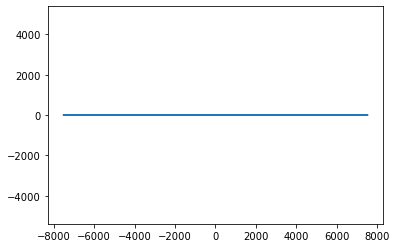

In [31]:
plt.plot(x_inert,y_inert)
plt.axes().set_aspect('equal', 'datalim')


# Plot in Earth reference frame

In [32]:
target_frame = earthFrame
x_earth = []
y_earth = []

for time, tmp_s in zip(t,s):
    trans = inertialFrame.getTransformTo(target_frame, time)
    pos = trans.transformPosition(tmp_s.getPVCoordinates().getPosition())
    x_earth.append(pos.getX()/1000)
    y_earth.append(pos.getY()/1000)
    
plt.plot(x_earth,y_earth);
plt.axes().set_aspect('equal', 'datalim')

<ipython-input-32-9e7d5ce23527>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal', 'datalim')


# Sun oriented inertial frame

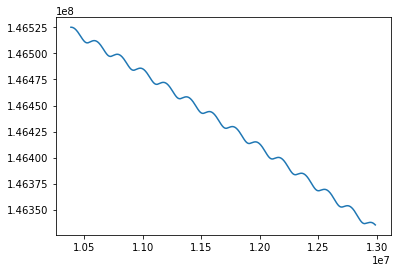

In [33]:
sun = CelestialBodyFactory.getSun()
target_frame = sun.getInertiallyOrientedFrame()

x_earth = []
y_earth = []

for tmp_t, tmp_s in zip(t,s):
    trans = inertialFrame.getTransformTo(target_frame, tmp_t)
    pos = trans.transformPosition(tmp_s.getPVCoordinates().getPosition())
    x_earth.append(pos.getX()/1000)
    y_earth.append(pos.getY()/1000)

plt.plot(x_earth,y_earth)


# Moon centered moon body oriented frame

<ipython-input-34-7a4b2cb78c96>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal', 'datalim')


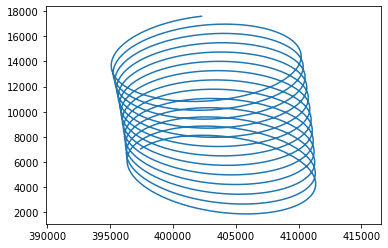

In [34]:
moon = CelestialBodyFactory.getMoon()
target_frame = moon.getBodyOrientedFrame()

x_earth = []
y_earth = []

for tmp_t, tmp_s in zip(t,s):
    trans = inertialFrame.getTransformTo(target_frame, tmp_t)
    pos = trans.transformPosition(tmp_s.getPVCoordinates().getPosition())
    x_earth.append(pos.getX()/1000)
    y_earth.append(pos.getY()/1000)
    
plt.plot(x_earth,y_earth)
plt.axes().set_aspect('equal', 'datalim')

# Using AbsolutePVCoordinates

There is a class in Orekit AbsolutePVCoordinates that contains all parameters to specify a PV coordinate in space and time.

In [35]:
apv = AbsolutePVCoordinates(eme_frame, initDate, position, velocity)
apv

<AbsolutePVCoordinates: {2000-01-01T12:08:39.816, P(3220103.0, 69623.0, 6449822.0), V(6414.7, -2006.0, -3180.0), A(0.0, 0.0, 0.0)}>

From this a PVCoordinate can be fetched in any frame:

In [36]:
apv.getPVCoordinates(station_frame)

<TimeStampedPVCoordinates: {2000-01-01T12:08:39.816, P(2717933.0799277574, 842497.7138440607, 265735.66483865934), V(4097.836310353481, -6224.178656863627, -902.6549534192495), A(-0.7768959573335615, -0.5621567085919928, 0.22851850659067963)}>

In [37]:
station_frame.getElevation(apv.getPosition(), apv.getFrame(), apv.getDate())

0.09311743352952996